# Recurrent Neural Networks (RNNs)


**FNNs** employ fixed-size vectors and have difficulties dealing with sequences of varying length: they fail to capture the temporal aspects of language.
**RNNs** solve this problem with a cycle within its network connections:

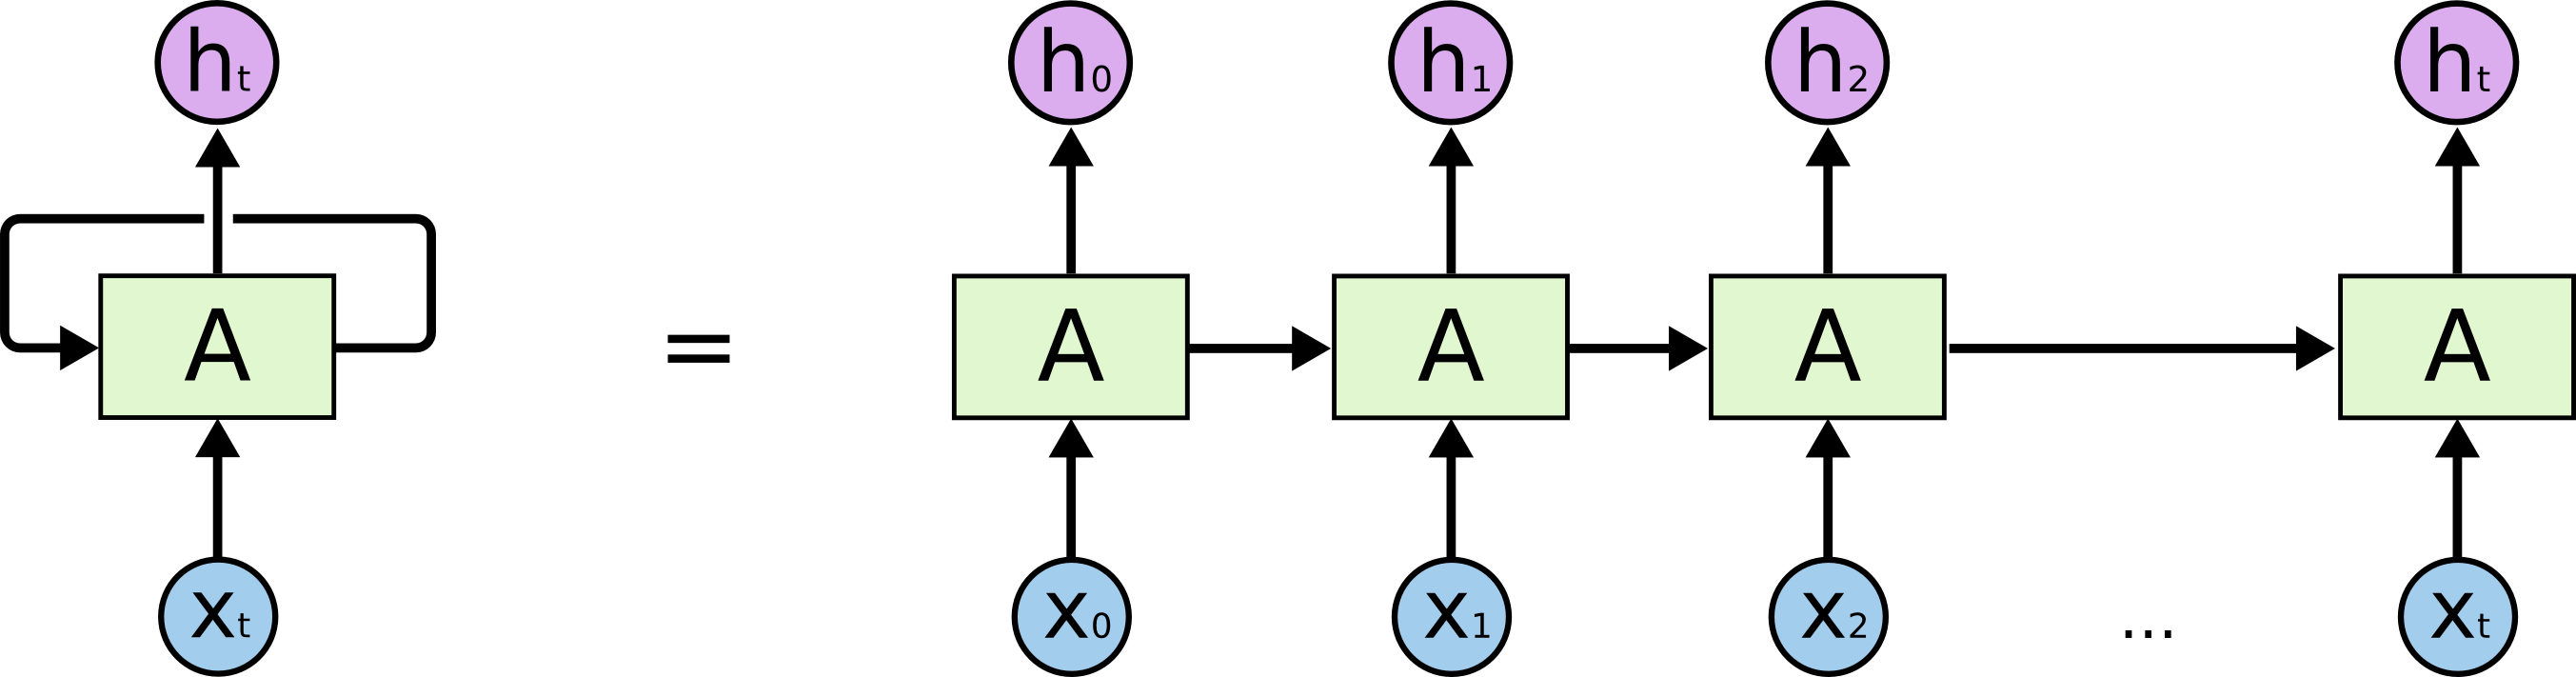
The activation value of the hidden layer depends on the current input as well as the activation value of the hidden layer from the previous time step.

**Forward inference** is similar to what we saw with FNNs:
$$\begin{align}
   &h_t = g(Uh_{t-1}+Wx_t)\newline
   &y_t=f(Vh_t)
   \end{align}$$
This is an **incremental inference algorithm**, it can be interpreted as unrolling the network in time:
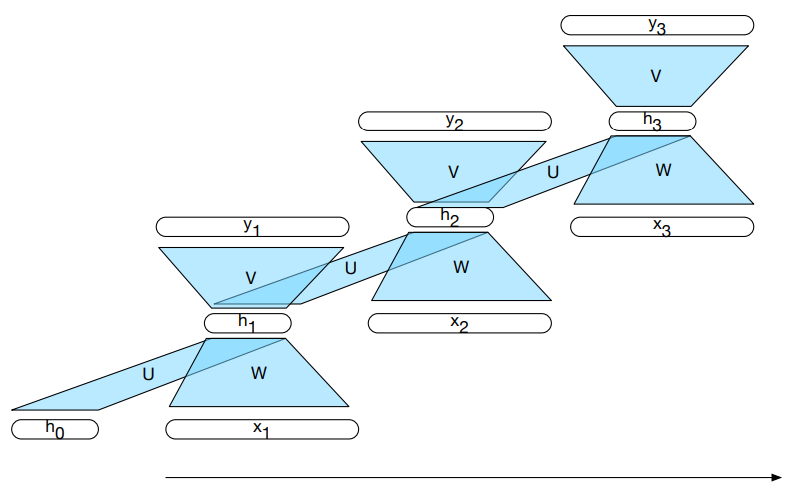

## To complete 

### Example: Sentiment classification on a moview review dataset
The following example is taken from: https://github.com/Harvard-IACS/2019-CS109B/blob/master/content/labs/lab6/cs109b-lab6-rnn-solutions.ipynb

A sentence can be thought of as a sequence of words which have semantic connections across time.

In [2]:
# !pip3 install numpy
# !pip3 install tensorflow
# !pip3 install keras

import numpy as np
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, SimpleRNN
from keras.layers.embeddings import Embedding
from keras.layers import Flatten
from keras.preprocessing import sequence
from keras.layers.embeddings import Embedding

# fix random seed for reproducibility
np.random.seed(1)


We define some parameters:

In [4]:
# take the 10000 most common words
VOCABULARY_SIZE = 10000

#Finite length of the review (avoid long sentences)
MAX_REVIEW_LENGTH = 500


EMBEDDING_DIM = 100

Normally, we would proceed by **tokenising** the text, but the IMDB dataset is already tokenised.
Then **load the data**:

In [9]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=VOCABULARY_SIZE)

print('First review', X_train[0])
print('Length of first and fifth review', len(X_train[0]) ,len(X_train[4]))

First review [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
Length of first and fifth review 218 147


We now **pre-process data** by ensuring that all inputs have same sentence length and dimensions. We use Keras' `sequence.pad_sequences()` function:

In [10]:
X_train = sequence.pad_sequences(X_train, maxlen=MAX_REVIEW_LENGTH)
X_test = sequence.pad_sequences(X_test, maxlen=MAX_REVIEW_LENGTH)
print('Length of first and fifth review after padding', len(X_train[0]) ,len(X_train[4]))

Length of first and fifth review after padding 500 500


#### FNNs with embeddings

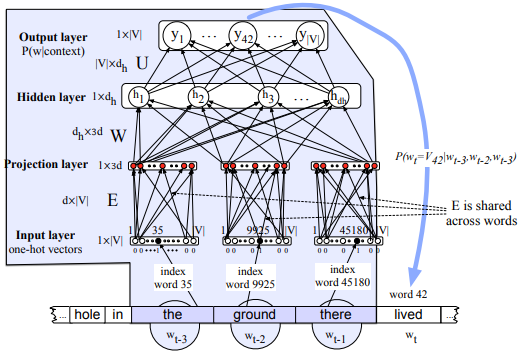

We build a single layer FNN with 250 nodes. Each input will be a 500-dim vector of tokens (remember padding).

In [9]:
#instantiate the model. Sequential groups a linear stack of layers into the model.
model = Sequential()

#add the embedding layer
model.add(Embedding(VOCABULARY_SIZE, EMBEDDING_DIM, input_length=MAX_REVIEW_LENGTH))

#we flatten the input layer to one dimension
model.add(Flatten())

#hidden layer
model.add(Dense(250, activation='relu'))

#output layer 
model.add(Dense(1, activation='sigmoid'))

#configure model for training
model.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 100)          1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 50000)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 250)               12500250  
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 251       
Total params: 13,500,501
Trainable params: 13,500,501
Non-trainable params: 0
_________________________________________________________________
None


Now we fit the model and evaluate its performance:

In [10]:
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2, batch_size=128, verbose=2)

# Evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/2
196/196 - 16s - loss: 0.6928 - accuracy: 0.5125 - val_loss: 0.6928 - val_accuracy: 0.5130
Epoch 2/2
196/196 - 16s - loss: 0.6917 - accuracy: 0.5282 - val_loss: 0.6923 - val_accuracy: 0.5152
Accuracy: 51.52%


### Simple RNN

Similar procedure, but here hidden states arec created using the state variable from the previous timestep and the input at current time.

In [5]:
#instantiate the model. Sequential groups a linear stack of layers into the model.
model = Sequential()

#add the embedding layer
model.add(Embedding(VOCABULARY_SIZE, EMBEDDING_DIM, input_length=MAX_REVIEW_LENGTH))

#add a fully-connected RNN with 100 units
model.add(SimpleRNN(100))

#output layer
model.add(Dense(1, activation='sigmoid'))

#configure model for training
model.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 100)          1000000   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 100)               20100     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 1,020,201
Trainable params: 1,020,201
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
#fit the model
model.fit(X_train, y_train, epochs=2, batch_size=128)

# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/2
196/196 [==============================] - 29s 147ms/step - loss: 0.6651 - accuracy: 0.6058
Epoch 2/2
196/196 [==============================] - 29s 149ms/step - loss: 0.6603 - accuracy: 0.6134
Accuracy: 58.76%


During backpropagation, simple RNNs can have ***vanishing gradients***. In fact, calculating the derivative of the sigmoid:
$$\sigma(z)=\frac{1}{1+e^{-x}}\quad \to \quad \frac{d\sigma}{dz}=\sigma(z)(1-\sigma(z))$$

### LSTMs

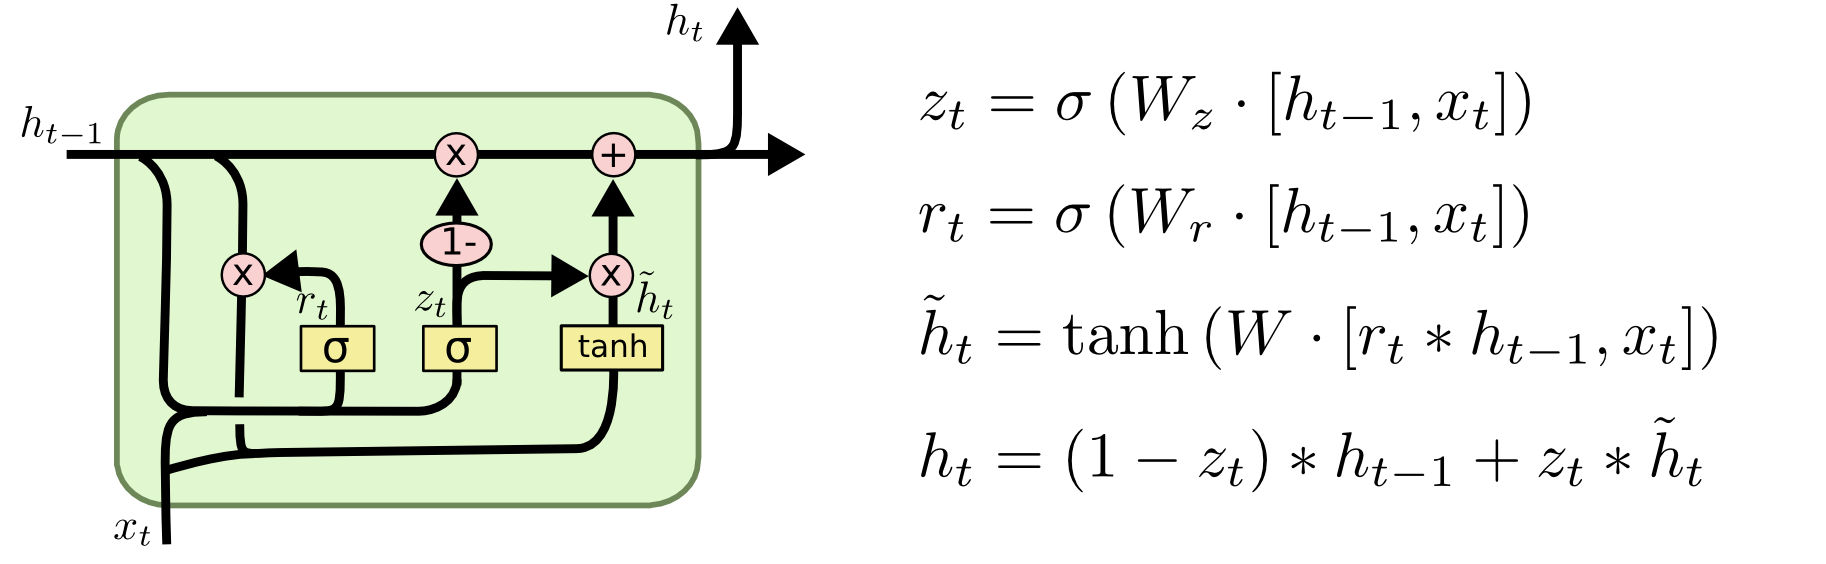